Project: # Patil_ADEarlyDetection

# **Phase 1:**  
## CNN with TL = ResNet125v2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from keras.applications.densenet import DenseNet169, DenseNet121, DenseNet201 #https://keras.io/api/applications/densenet/
from keras.applications import VGG16, VGG19 #https://keras.io/api/applications/vgg/
from keras.applications.resnet_v2 import ResNet152V2 #https://keras.io/api/applications/

from keras.applications.vgg19 import preprocess_input
from keras.applications.resnet_v2 import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint

import numpy as np

from matplotlib import pyplot as plt

import sys
sys.path.append('/content/drive/My Drive/AD_proj')

# Base Model choice
NUM_CHOICE_INCEPTIONV3 = 1
NUM_CHOICE_VGG16 = 2
NUM_CHOICE_VGG19 = 3
NUM_CHOICE_DENSENET121 = 4
NUM_CHOICE_DENSENET169 = 5
NUM_CHOICE_DENSENET201 = 6
NUM_CHOICE_RESNET50 = 7
NUM_CHOICE_RESNET152V2 = 8

target_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

#
# Define constants
#
NUM_EPOCH =  100
NUM_PATIENCE =  20

NUM_BATCH_SIZE = 128
NUM_IMAGE_SIZE =224
NUM_VAL_SPLIT = 0.2
NUM_IMG_RESCALE = 1/255
NUM_LEARNING_RATE = 0.001 #Choose form [1e-2, 1e-3, 1e-4]

# To prevent overfitting
NUM_DROPOUT_RATE=0.5
NUM_FILL_GRAY = 125.0

In [ ]:
# DATA AUGMENTATION:  
# Augment the train data to make sure each EPOCH does NOT train on same image
# i.e. train data will be augmented on every epoch
train = ImageDataGenerator(preprocessing_function=preprocess_input, 
                           validation_split=NUM_VAL_SPLIT,
                           rotation_range=40,
                           zoom_range=NUM_VAL_SPLIT,
#                           width_shift_range=NUM_VAL_SPLIT, 
#                           height_shift_range=NUM_VAL_SPLIT,
#                           fill_mode='constant', 
#                           cval=NUM_FILL_GRAY,                            
                           horizontal_flip=True, 
                           vertical_flip=True, 
                           rescale=NUM_IMG_RESCALE)

val = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)
test = ImageDataGenerator(preprocessing_function=preprocess_input, validation_split=NUM_VAL_SPLIT, rescale=NUM_IMG_RESCALE)

train_dataset = train.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='training')

val_dataset = val.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/train', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical', 
    subset='validation')

test_dataset = test.flow_from_directory(
    '/content/drive/My Drive/AD_proj/Alzheimer_s_Dataset/test', 
    target_size=(NUM_IMAGE_SIZE, NUM_IMAGE_SIZE), 
    batch_size=NUM_BATCH_SIZE, 
    class_mode='categorical')

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [ ]:
# All Helper functions
#--------------------------------------------------------------------
# Function Name: f_ad_model_builder
# Description: Build Convolutional Neural Network (CNN) Deep learning model
#              for early diagnosis of Alzheimer's disease
#--------------------------------------------------------------------
def f_ad_model_builder():

  
  # Set include tope=False, so fully-connected output layers of the model used to make predictions is not loaded, allowing a new output layer to be added and trained
  model_tl = ResNet152V2(input_shape=(NUM_IMAGE_SIZE,NUM_IMAGE_SIZE,3), include_top=False, weights="imagenet")

  # freeze layers
  for layer in model_tl.layers :
    layer.trainable = False

  model = Sequential() # seq model is a linear stacks of layers
  model.add(model_tl)

  # Dropout to prevent overfitting
  # Train model on some layer outputs are randomly ignored or “dropped out.” 
  # This has the effect of making the layer look-like and be treated-like a layer with a different 
  # number of nodes and connectivity to the prior layer.
  model.add(Dropout(rate=0.5))

  # Flatten: Rectangular or cubic shapes can't be direct inputs & connected layer. 
  # We flatten the output of the convolutional layers to create a 1-dimentional array (single long feature vector)
  model.add(Flatten())

  # Dense Layer 1 
  model.add(BatchNormalization()) # Batch Normalization: to imporve the training speed
  model.add(Dense(units=2048, kernel_initializer='he_uniform'))

  # Dense Layer 2
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=1024, kernel_initializer='he_uniform'))

  # Final Dense Layer
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(rate=0.5))
  model.add(Dense(units=4, activation='softmax'))

  # printout whole model: Hidden layer + Dense Layer
  model.summary()
 
  #
  # COMPILE: Choose learning rate from 0.01, 0.001, or 0.0001 i.e. [1e-2, 1e-3, 1e-4]
  # Optimizer: optimizers shape and mold your model into its most accurate possible form by manipulating weights
  model.compile(optimizer = keras.optimizers.Adam(learning_rate = NUM_LEARNING_RATE),
                loss = 'categorical_crossentropy', 
                metrics = [tf.keras.metrics.AUC(name = 'auc')])
  
  return model

#--------------------------------------------------------------------
# Function Name: f_ad_plot_auc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_auc_loss(f_model):

  # create subplots
  fig, axs = plt.subplots(1,2,figsize=(15,10))

  ticks = np.arange(1,len(f_model.history['loss'])+1)
  history_auc_length = len(f_model.history['auc'])+1
  history_val_auc_length = len(f_model.history['val_auc'])+1
  history_loss_length = len(f_model.history['loss'])+1
  history_val_loss_length = len(f_model.history['val_loss'])+1

  # Summarize history for auc
  axs[0].plot(range(1,history_auc_length), f_model.history['auc'])
  axs[0].plot(range(1,history_val_auc_length), f_model.history['val_auc'])
  axs[0].set_title('Model AUC')
  axs[0].set_ylabel('AUC')
  axs[0].set_xlabel('Epoch')
  axs[0].set_xticks(ticks,len(f_model.history['auc'])/10)
  axs[0].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

  # Summarize history for loss
  axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
  axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epoch')
  axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
  axs[1].legend(['train', 'val'], loc='best', bbox_to_anchor=(1,1))

#--------------------------------------------------------------------
# Function Name: f_ad_plot_acc_loss
# Description: 
#              
#--------------------------------------------------------------------
def f_ad_plot_acc_loss(f_model):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,10))
    ticks = np.arange(1,len(f_model.history['loss'])+1)
    history_acc_length = len(f_model.history['accuracy'])+1
    history_val_accuracy_length = len(f_model.history['val_accuracy'])+1
    history_loss_length = len(f_model.history['loss'])+1
    history_val_loss_length = len(f_model.history['val_loss'])+1

    # Summarize history for accuracy
    axs[0].plot(range(1,history_acc_length), f_model.history['accuracy'])
    axs[0].plot(range(1,history_val_accuracy_length), f_model.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(ticks,len(f_model.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Summarize history for loss
    axs[1].plot(range(1, history_loss_length), f_model.history['loss'])
    axs[1].plot(range(1,history_val_loss_length), f_model.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Show the plot
    plt.show()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

/content/proj_ADEarlyDetection_helper_functions.py:165: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[0].set_xticks(ticks,len(f_model.history['auc'])/10)
/content/proj_ADEarlyDetection_helper_functions.py:174: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  axs[1].set_xticks(ticks,len(f_model.history['loss'])/10)


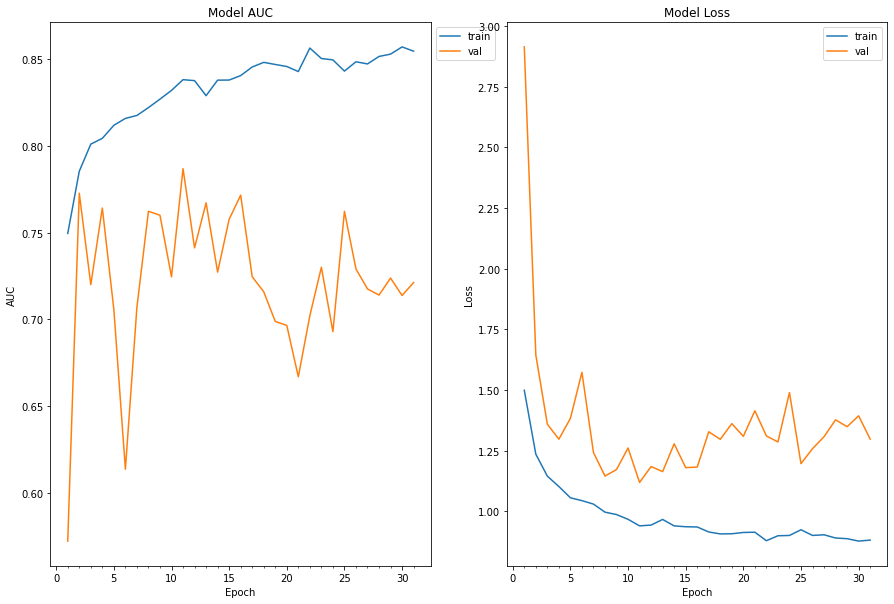

In [ ]:
# Build model (with chosen of transport layer base Model)
model = f_ad_model_builder()

# Define callbacks
save_model_path = '/content/drive/My Drive/AD_proj/my_best_models/proj_adEarlyDetection_resNet152V2_rev0.hdf5'
checkpoint = ModelCheckpoint(save_model_path, monitor='val_auc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor='val_auc', min_delta=0, patience=NUM_PATIENCE, verbose=1, mode='max') 


# Train the model
tic = time.perf_counter()
model_trained=model.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs = NUM_EPOCH,
                        callbacks = [checkpoint, early],
                        verbose = 1)

toc = time.perf_counter()
print("Train Time:{}".format(round((toc-tic)/60,2)))
print('--------------------------------------------\n')

#print(f'Results [with ' + tl_names[this_tl_choice-1] + ' TL]:')
f_ad_plot_auc_loss(model_trained)

In [ ]:
# load model
loaded_model = load_model(filepath='/content/drive/My Drive/AD_proj/my_best_models/proj_adEarlyDetection_resNet152V2_rev0.hdf5')
#Evaluate Test data
print("Evaluate on test data")
test_results = loaded_model.evaluate(test_dataset, batch_size=NUM_BATCH_SIZE)
#test_results = model_trained.evaluate(test_dataset, batch_size=NUM_BATCH_SIZE)
print("Test loss, Test auc:", test_results)

# Predict: Generate predictions
test_pred = loaded_model.predict(test_dataset)
test_pred_classes = np.argmax(test_pred, axis=1)

#print ('-----------------------------------------------------')
#print('Confusion Matrix [test DataSet]')
cm = confusion_matrix(test_dataset.classes, test_pred_classes)

print ('-----------------------------------------------------')
print('Classification Report [Test Data]')
print(classification_report(test_dataset.classes, test_pred_classes, target_names=target_names))

print ('-----------------------------------------------------')
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)


Confusion matrix, without normalization
[[  0   0 179   0]
 [  0   0  12   0]
 [  0   0 638   2]
 [  0   0 445   3]]


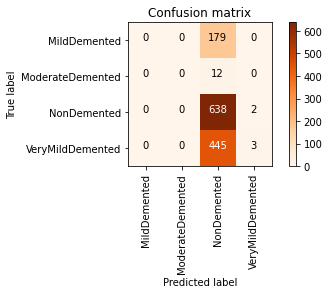

In [ ]:
#plot the matrix
f_ad_plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion matrix', cmap=plt.cm.Oranges)